# Проект: Анализ результатов A/B-тестирования для интернет-магазина

- Автор: Елагина Ксения

## Введение

### Цели и задачи проекта

Необходимо оценить корректность проведения A/B-теста для интернет-магазина, который продаёт товары для активного и здорового образа жизни, и проанализировать его результаты.

**Задачи проекта:**

- Загрузить данные и проверить их целостность.
- Проверить корректность проведения A/B-теста на:
  - соответствие требованиям технического задания.
  - равномерность распределения пользователей по группам теста.
- Проанализировать результаты A/B-теста.
- Сделать выводы и дать рекомендации.

## Загрузка данных и знакомство с ними


In [1]:
# Импортируем библиотеки
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

### Вывод общей информации

In [2]:
# Выгружаем данные
participants = pd.read_csv('/datasets/ab_test_participants.csv')
events = pd.read_csv('/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [3]:
# Выведем информацию о датафрейме:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [4]:
# Проверим датафрейм на наличие дубликатов
participants.duplicated().sum()

0

Датасет participants содержит 14525 столбцов и 4 строки, в которых представлена информация об участниках тестов.

После первичного анализа данных можно сделать следующие выводы:

- В таблице представлены полные данные, нет пропусков и дубликатов.
- Типы данных соответствуют требованиям.
- Для удобства аналитик мог бы разделить данную таблицу на несколько, чтобы удобнее было узнавать информацию о конкретном тесте.

In [5]:
# Выведем информацию о датафрейме:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [6]:
# Найдем количество пропусков в столбце
events['details'].isna().sum()

538264

In [7]:
# Проверим датафрейм на наличие дубликатов
events.duplicated().sum()

36318

Датасет participants содержит 787286 столбцов и 4 строки, в которых представлена информация о событиях 2020 года.

После первичного анализа данных можно сделать следующие выводы:

- В столбце details содержится 538264 пропуска. В данном столбце содержатся детали события (у registration - стоимость привлечения клиента, у purchase - стоимость покупки), также некоторые события содержат информацию о местности, в которой произошло целевое действие. Пропуски могли возникнуть из-за того, что пользователи не указывали в интернет-магазине свое местоположение или оно не было определено автоматически.
- Необходимо иметь ввиду, что в столбце details стоимость привлечения пользователей указана в отрицательных значениях и также неизвестна валюта исчисления.
- Можно было бы создать несколько столбцов вместо details, чтобы каждый имел свою информацию и правильные типы данных.
- В столбце user_id у некоторых пользователей вместо id находится слово 'GLOBAL'. Возможно, данные действия были выполнены незарегистрированными пользователями. Эти строки аналитику тоже необходимо было удалить, чтобы не исказить результаты анализа и стат теста.  
- Типы данных соответствуют требованиям.
- В таблице найдено 36318 дубликатов. Аналитику также необходимо было их удалить. 

## Оценка корректности проведения теста

**Нулевая гипотеза** - упрощение интерфейса не повлияет на конверсию или она увеличиться менее, чем на 3%.

**Альтернативная гипотеза** - упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

In [8]:
# Создадим датафрейм из пользователей с необходимым тестом
interface_participants = participants[participants['ab_test'] == 'interface_eu_test']

# Проверим датафрейм на наличие дубликатов в айди пользователей
interface_participants['user_id'].duplicated().sum()

0

In [9]:
# выведем кол-во пользователей в каждой группе 
users_by_group = interface_participants.groupby('group')['user_id'].nunique().reset_index(name='count')
users_by_group

,group,count
0,A,5383
1,B,5467


In [10]:
# найдем процентную разницу между группами
a = users_by_group['count'][0]
b = users_by_group['count'][1]

round(100*abs(a-b)/((a+b)/2), 2)


1.55

<Figure size 1000x600 with 0 Axes>

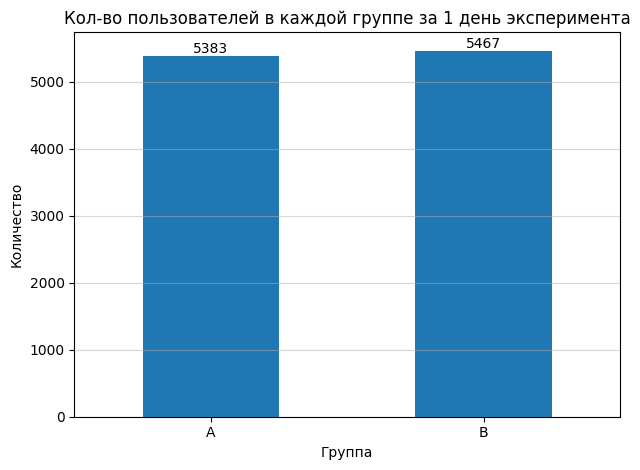

In [11]:
# построим график
plt.figure(figsize=(10,6))

users_by_group_ax = users_by_group.set_index('group').plot(kind='bar',
                                            rot=0,
                                            legend = False)

plt.xlabel("Группа")
plt.ylabel("Количество")
plt.title('Кол-во пользователей в каждой группе за 1 день эксперимента')

users_by_group_ax.bar_label(users_by_group_ax.containers[0])
plt.grid(True, alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

In [12]:
# создадим множества с айди пользователей
users_A = set(interface_participants[interface_participants['group'] == 'A']['user_id'])
users_B = set(interface_participants[interface_participants['group'] == 'B']['user_id'])
# выведем количество пользователей, которые встречаются одновременно в группах A и B
len(users_A&users_B)

0

Исправим допущенные ошибки.

In [13]:
# создадим датафрейм без дубликатов
events_clean = events.drop_duplicates()

# проверим на наличие дубликатов
events_clean.duplicated().sum()

0

In [14]:
# удалим строки с неизвестным айди пользователя
events_clean = events_clean[events_clean['user_id']!='GLOBAL']

### Анализ данных о пользовательской активности

In [15]:
# объединим 2 предобработанные таблицы
df = interface_participants.merge(events_clean, how='left', on='user_id')

Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации.

In [16]:
# приведем event_dt к datetime
df['event_dt'] = pd.to_datetime(df['event_dt'])

# создадим таблицу с датами регистрации
df_registration = df[df['event_name']=='registration'].groupby('user_id')['event_dt'].min().reset_index(name='registration_dt')

# соединим таблицы
df_new = df.merge(df_registration, how='left', on='user_id')

# создадим новый столбец с разницей в timedelta
df_new['lifetime'] = df_new['event_dt'] - df_new['registration_dt']

# оставим события в первые 7 дней
df_new = df_new[df_new['lifetime']<=pd.Timedelta('7D')]

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Зададим следующие параметры:
- базовый показатель конверсии — 30%,
- мощность теста — 80%,
- достоверность теста — 95%.

Расчитаем необходимый размер выборки с помощью калькулятора.

https://www.evanmiller.org/ab-testing/sample-size.html#!30;80;5;3;0

Получаем, что необходимый размер групп равен **3692** чел.

In [17]:
# проверим размер выборки А:
df_new[df_new['group']=='A']['user_id'].nunique()

5383

In [18]:
# проверим размер выборки В:
df_new[df_new['group']=='B']['user_id'].nunique()

5467

Выборки достаточны.

Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [19]:
# посчитаем количество посетителей
n_a = df_new[df_new['group']=='A']['user_id'].nunique()
n_b = df_new[df_new['group']=='B']['user_id'].nunique()

# посчитаем количество покупателей
m_a = df_new[(df_new['group']=='A')&(df_new['event_name']=='purchase')]['user_id'].nunique()
m_b = df_new[(df_new['group']=='B')&(df_new['event_name']=='purchase')]['user_id'].nunique()

# выведем результат
print(f"Общее количество посетителей в группе А - {n_a}, в группе В - {n_b}.\nКоличество посетителей в группе А, сделавших покупку, - {m_a}, а в группе В - {m_b}.")

Общее количество посетителей в группе А - 5383, в группе В - 5467.
Количество посетителей в группе А, сделавших покупку, - 1480, а в группе В - 1600.


In [20]:
# посчитаем конверсию
p_a = round(m_a/n_a*100,2)
p_b = round(m_b/n_b*100,2)
# выведем результат
print(f"Конверсия группы А составляет - {p_a}%, группы В - {p_b}.")

Конверсия группы А составляет - 27.49%, группы В - 29.27.


In [21]:
# посчитаем разницу конверсий
p_b - p_a

1.7800000000000011

Конверсия тестовой группы увеличилась на 1.8%. Альтернативная гипотеза не подтвердилась - упрощение интерфейса не привело к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличилась как минимум на три процентных пункта.


### Оценка результатов A/B-тестирования

Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

**Нулевая гипотеза** - разница конверсий 2х групп составляет как минимум 3%.

**Альтернативная гипотеза** - разница конверсий меньше 3%.

In [22]:
from statsmodels.stats.proportion import proportions_ztest

# уровень значимости
alpha = 0.05

# проведем z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.020306993983065475 < 0.05
Нулевая гипотеза не находит подтверждения!


### Общий вывод и рекомендации

Статистический тест показывает, что нулевая гипотеза подтвердилась - упрощение интерфейса не привело к увеличению конверсии зарегистрированных пользователей в покупателей на 3% и более. Конверсия тестовой группы увеличилась лишь на 1.8%.

**Рекомендации для магазина:**  
  - Провести дополнительный анализ поведения пользователей, чтобы выявить узкие места в воронке.  
  - Протестировать другие гипотезы по улучшению интерфейса или пользовательского пути.